In [69]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.ioff()
plt.style.use('ggplot')
import json
import os

## Import data

In [70]:
with open('../data/tracks_fourier.json') as f:
    data = json.load(f)

In [71]:
DESCRIPTORS_ORDER = 2**8
SMOOTHING_ORDER = 2**6

fourier_orders = []
for track in data.values():
    fourier_orders.append(len(track['fourier-descriptors']['real']))
assert(min(fourier_orders) == max(fourier_orders) == DESCRIPTORS_ORDER)

def truncate_descriptors(a):
    assert(SMOOTHING_ORDER<len(a))
    mid = len(a) // 2
    low  = mid - SMOOTHING_ORDER // 2
    high = mid + SMOOTHING_ORDER // 2
    return np.fft.fftshift(a)[low:high]

def pad_descriptors(a):
    assert(DESCRIPTORS_ORDER>len(a))
    mid = DESCRIPTORS_ORDER // 2
    low  = mid - SMOOTHING_ORDER // 2
    high = mid + SMOOTHING_ORDER // 2
    a_padded = np.zeros(DESCRIPTORS_ORDER, np.complex_)
    a_padded[low:high] = a
    return np.fft.fftshift(a_padded)

### Data visualization

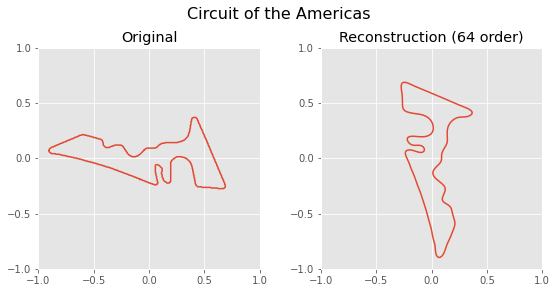

In [97]:
track_name_example = 'Circuit of the Americas'
track_data = data[track_name_example]

track_descp = np.array([ r + 1j * i for r,i in zip(track_data['fourier-descriptors']['real'], track_data['fourier-descriptors']['imag'])])
track_descp_trunc = truncate_descriptors(track_descp)
track_descp_padded = pad_descriptors(track_descp_trunc)
track_smoothed = np.fft.ifft(track_descp_padded)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
fig.suptitle(track_name_example, fontsize=16)
for ax in axs:
    ax.set_xlim(-1, 1)
    ax.set_xticks(np.linspace(-1., 1., 5))
    ax.set_ylim(-1, 1)
    ax.set_yticks(np.linspace(-1., 1., 5))
    ax.set_aspect('equal')
axs[0].plot(*np.array(track_data['points']).transpose())
axs[0].set_title('Original')
axs[1].plot(track_smoothed.real, track_smoothed.imag)
axs[1].set_title('Reconstruction ({} order)'.format(SMOOTHING_ORDER))

plt.tight_layout()
plt.show()
plt.close(fig)

In [73]:
path_save = '../data/tracks_smoothed{}_plots'.format(SMOOTHING_ORDER)

if not os.path.exists(path_save):
    os.makedirs(path_save)

for name, track_data in data.items():
    track_descp = np.array([ r + 1j * i for r,i in zip(track_data['fourier-descriptors']['real'], track_data['fourier-descriptors']['imag'])])
    track_descp_trunc = truncate_descriptors(track_descp)
    track_descp_padded = pad_descriptors(track_descp_trunc)
    track_smoothed = np.fft.ifft(track_descp_padded)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(track_smoothed.real, track_smoothed.imag)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(name)
    ax.set_aspect('equal')
    fig.savefig(path_save+'/'+name.replace(' ', '_')+'.png', dpi=250)
    plt.close(fig)

## Create dataset

In [132]:
data_training = []
for track in data.values():
    track_descp_complex = np.array([ r + 1j * i for r,i in zip(track['fourier-descriptors']['real'], track['fourier-descriptors']['imag'])])
    track_descp_trunc = truncate_descriptors(track_descp_complex)
    data_training.append(track_descp_trunc)
data_training = np.array(data_training)
print(data_training.shape, data_training.dtype)

(77, 64) complex128


### Data augmentation (rotation)

In [135]:
rotation_augmentation_factor = 6
data_training_augmented = [data_training * np.exp(1j * np.pi * i * 2 / rotation_augmentation_factor) for i in range(rotation_augmentation_factor)]
data_training_augmented = np.concatenate(data_training_augmented, axis=0)
print(data_training_augmented.shape, data_training_augmented.dtype)

(462, 64) complex128


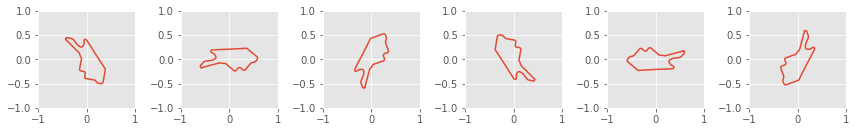

In [136]:
fig, axs = plt.subplots(1,rotation_augmentation_factor, figsize = (2*rotation_augmentation_factor, 3))

for ax, i in zip(axs,[i * data_training.shape[0] for i in range(rotation_augmentation_factor)]):
    track_descp_padded = pad_descriptors(data_training_augmented[i])
    track_smoothed = np.fft.ifft(track_descp_padded)
    ax.plot(track_smoothed.real, track_smoothed.imag)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()
plt.close(fig)